# Imports

In [1]:
# PyABC imports
from pyabc import (ABCSMC, Distribution, RV,
                   History, MedianEpsilon)
from pyabc.populationstrategy import AdaptivePopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler

In [2]:
# Custom imports
from ionchannelABC import (ion_channel_sum_stats_calculator,
                           IonChannelAcceptor,
                           IonChannelDistance,
                           EfficientMultivariateNormalTransition,
                           calculate_parameter_sensitivity,
                           plot_parameters_kde,
                           plot_parameter_sensitivity,
                           plot_regression_fit)

INFO:myokit:Loading Myokit version 1.27.4


In [3]:
# Other necessary imports
import numpy as np
import subprocess
import pandas as pd
import io
import os
import tempfile

In [4]:
# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

# Create ion channel model

In [5]:
from channels.ical_generic import ical as model
model.sample({})

,x,y,exp
0,-39.999900,-0.621047,0
1,-29.999900,-2.148337,0
2,-19.999900,-6.428213,0
3,-9.999900,-13.570926,0
4,0.000100,-18.084118,0
5,10.000100,-17.854995,0
6,20.000100,-15.466291,0
7,30.000100,-12.496283,0
8,40.000100,-9.395486,0
9,50.000100,-6.267236,0


# Get experimental measurements

In [10]:
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

# Set limits and generate uniform initial priors

In [11]:
limits = dict(g_CaL=(0, 10),
              v_offset=(0, 100),
              Vhalf_d=(-100,100),
              k_d=(0,50),
              c_bd=(0,10),
              c_ad=(0,10),
              sigma_d=(0,100),
              Vmax_d=(-100,100),
              Vhalf_f=(-100,100),
              k_f=(-50,0),
              c_bf=(0,1000),
              c_af=(0,10000),
              sigma_f=(0,100),
              Vmax_f=(-100,100),
              ca_dep_fCa=(0, 1),
              tau_fCa=(0,100))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Test parameter sensitivity

In [8]:
parameters = ['ical.'+k for k in limits.keys()]

In [9]:
distance_fn=IonChannelDistance(
    obs=obs,
    exp_map=exp,
    err_bars=errs,
    err_th=0.1)

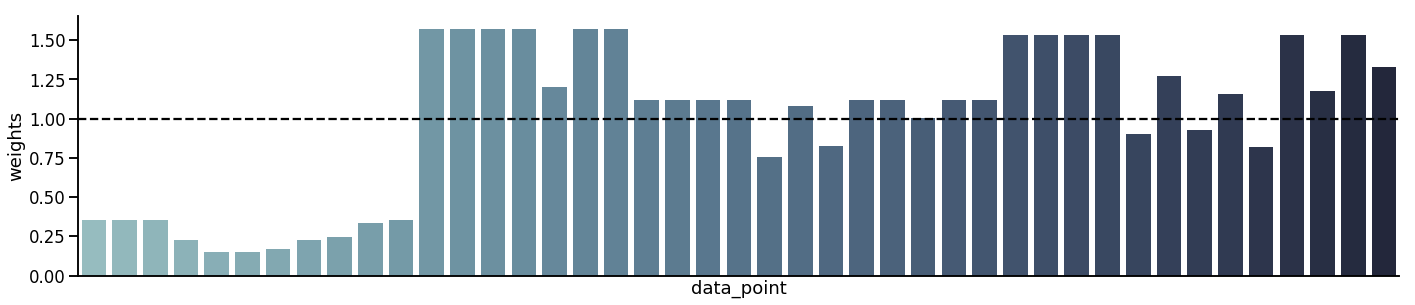

In [10]:
from ionchannelABC import plot_distance_weights
sns.set_context('talk')
grid = plot_distance_weights(model, distance_fn)
grid.savefig('results/ical-generic/dist_weights.pdf')

In [11]:
fitted, regression_fit, r2 = calculate_parameter_sensitivity(
    model,
    parameters,
    distance_fn,
    sigma=0.05,
    n_samples=1000)

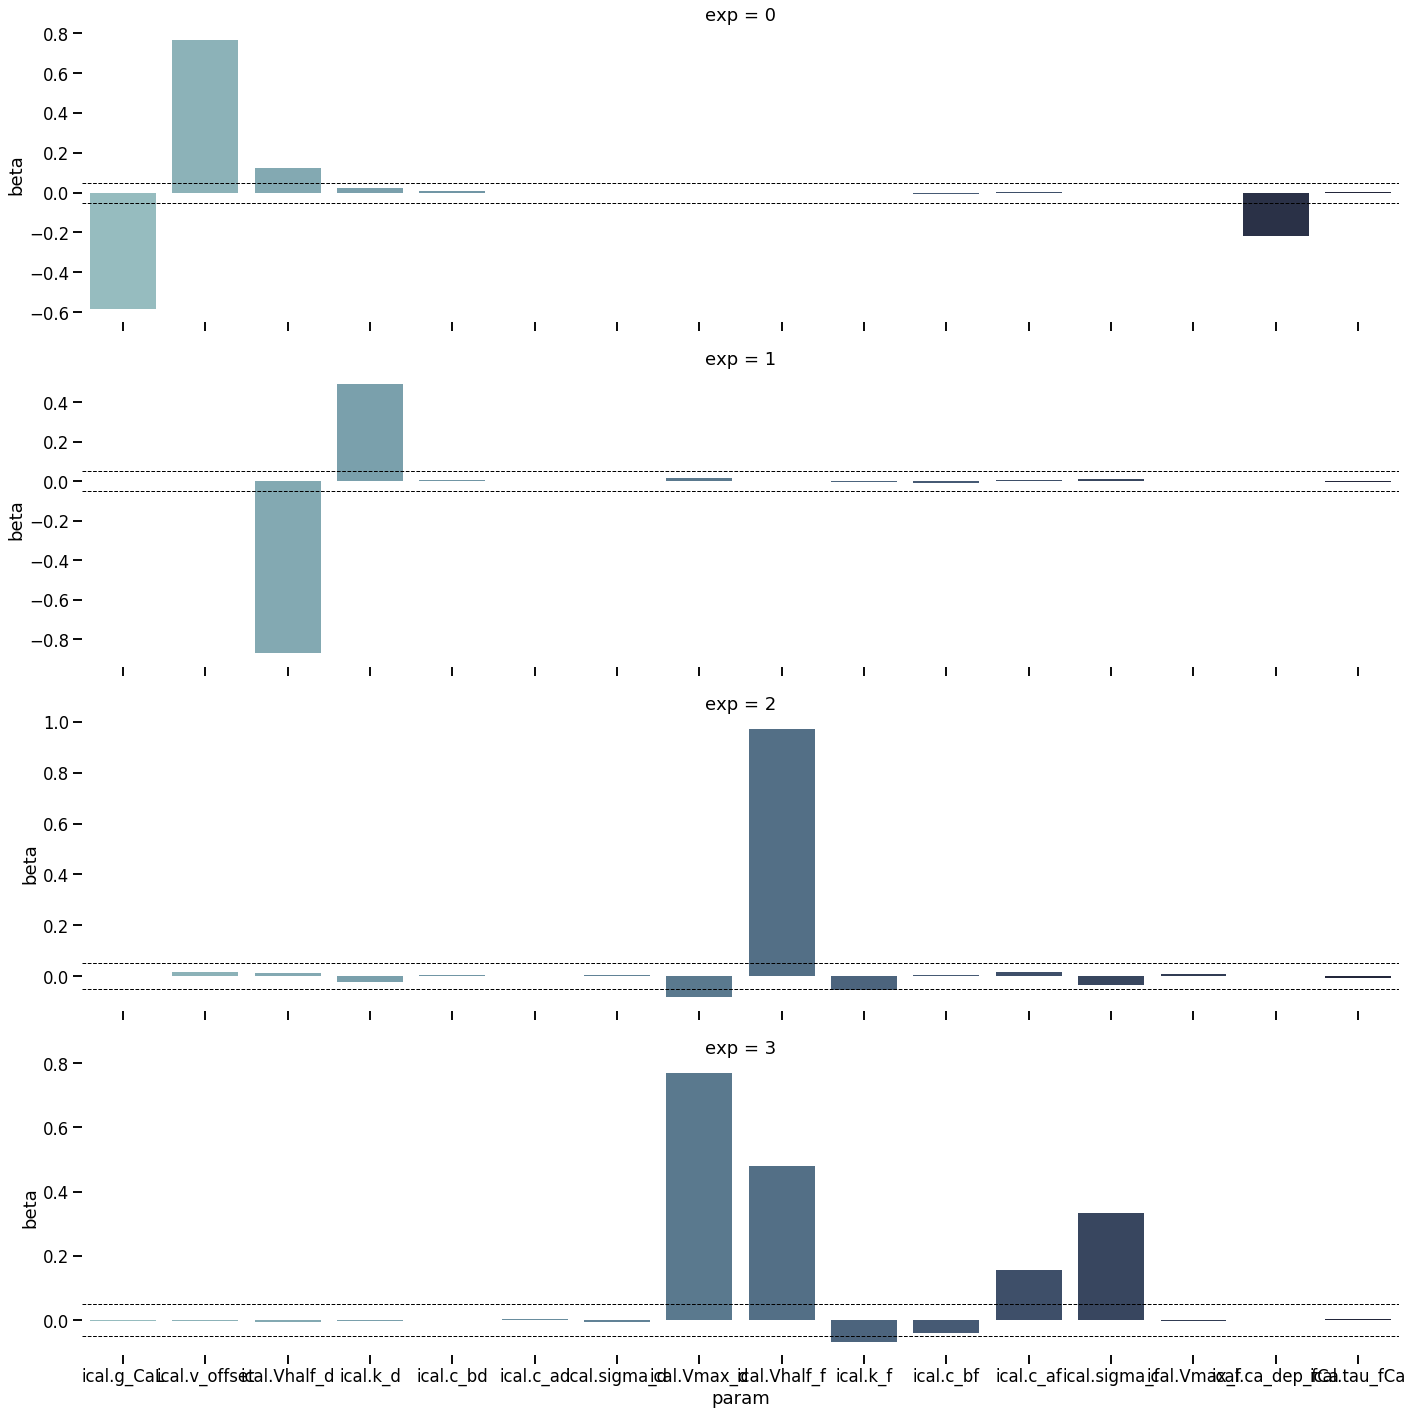

In [12]:
sns.set_context('talk')
grid = plot_parameter_sensitivity(fitted, plot_cutoff=0.05)

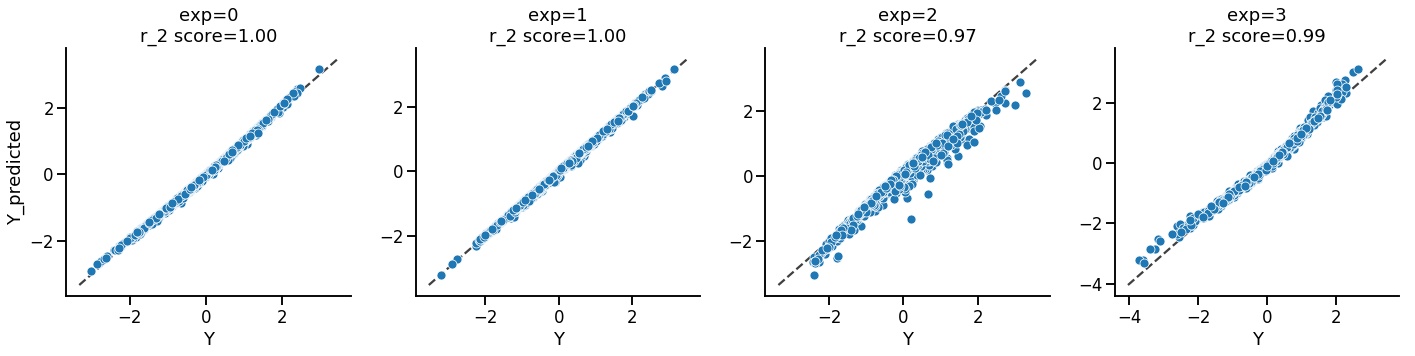

In [13]:
grid2 = plot_regression_fit(regression_fit, r2)

In [14]:
grid.savefig('results/ical-generic/sensitivity.pdf')
grid2.savefig('results/ical-generic/sensitivity_fit.pdf')

In [18]:
# Finding insensitive parameters
cutoff = 0.04
fitted_pivot = fitted.pivot(index='param',columns='exp')
insensitive_params = fitted_pivot[(abs(fitted_pivot['beta'][0])<cutoff) & (abs(fitted_pivot['beta'][1])<cutoff) &
             (abs(fitted_pivot['beta'][2])<cutoff) & (abs(fitted_pivot['beta'][3])<cutoff)].index.values

In [19]:
insensitive_limits = dict((k, limits[k[5:]]) for k in insensitive_params)
insensitive_prior = Distribution(**{key: RV("uniform", a, b - a)
                                 for key, (a,b) in insensitive_limits.items()})

In [20]:
insensitive_limits

{'ical.Vmax_f': (-100, 100),
 'ical.c_ad': (0, 1000),
 'ical.c_bd': (0, 100),
 'ical.sigma_d': (0, 100),
 'ical.tau_fCa': (0, 100)}

In [65]:
# Generate random samples for insensitive parameters
def generate_sample(insensitive_prior, n):
    samples = [dict() for i in range(n)]
    for i in range(n):
        parameters = insensitive_prior.rvs()
        sample = {key: value for key, value in parameters.items()}
        samples[i].update(sample)
    return samples

In [68]:
samples = generate_sample(insensitive_prior, 1000)

In [69]:
model.add_external_par_samples(samples)

In [70]:
# New limits eliminating insensitive parameters
limits = dict((k, limits[k]) for k in limits if k[5:] not in insensitive_params)

In [7]:
# Eliminate ca-dependent parameters as we don't explicitly test for ca_dependence
# but it will interact with other parameters
limits = dict(g_CaL=(0, 0.01),
              v_offset=(0, 200),
              Vhalf_d=(-200,200),
              k_d=(0,50),
              c_bd=(0,100),
              c_ad=(0,1000),
              sigma_d=(0,100),
              Vmax_d=(-200,200),
              Vhalf_f=(-100,100),
              k_f=(-50,0),
              c_bf=(0,1000),
              c_af=(0,10000),
              sigma_f=(0,100),
              Vmax_f=(-100,100),
              ca_dep_fCa=(0, 1),
              tau_fCa=(0,100))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Initialise pyabc database

In [23]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_ical-generic.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_ical-generic.db


In [24]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)
cv_logger = logging.getLogger('CV Estimation')
cv_logger.setLevel(logging.DEBUG)

In [25]:
from pyabc.populationstrategy import ConstantPopulationSize

In [26]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.1),
             population_size=ConstantPopulationSize(2000),
             #population_size=AdaptivePopulationSize(
             #    start_nr_particles=2000,
             #    mean_cv=0.4,
             #    max_population_size=2000,
             #    min_population_size=100),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 0.35660656938246293, 1: 0.35660656938246293, 2: 0.35660656938246293, 3: 0.2235508569788746, 4: 0.14818305191086062, 5: 0.14818305191086062, 6: 0.16990123682780803, 7: 0.22754257892652202, 8: 0.24501057926385836, 9: 0.3352837664439712, 10: 0.35660656938246293, 11: 1.574893351215255, 12: 1.574893351215255, 13: 1.574893351215255, 14: 1.574893351215255, 15: 1.1991074553643941, 16: 1.574893351215255, 17: 1.574893351215255, 18: 1.1217956589353755, 19: 1.1217956589353755, 20: 1.1217956589353755, 21: 1.1217956589353755, 22: 0.7585517117689706, 23: 1.0822285804786025, 24: 0.8281937231104962, 25: 1.1217956589353755, 26: 1.1217956589353755, 27: 1.0020504889481259, 28: 1.1217956589353755, 29: 1.1217956589353755, 30: 1.5324625057607502, 31: 1.5324625057607502, 32: 1.5324625057607502, 33: 1.5324625057607502, 34: 0.9039307823835155, 35: 1.2728821221318876, 36: 0.930913790812873, 37: 1.1550226663789356, 38: 0.8206739997955603, 39: 1.5324625057607502, 40: 1.1768155468

In [27]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=4, start_time=2018-11-21 16:19:15.440547, end_time=None)>
INFO:Epsilon:initial epsilon is 51.79682444475002


In [ ]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=30, min_acceptance_rate=0.01)

INFO:ABC:t:13 eps:3.936468923171104
DEBUG:ABC:now submitting population 13
DEBUG:ABC:population 13 done
DEBUG:ABC:
total nr simulations up to t =13 is 262678
DEBUG:Epsilon:new eps, t=14, eps=3.703300932201997
INFO:ABC:t:14 eps:3.703300932201997
DEBUG:ABC:now submitting population 14
DEBUG:ABC:population 14 done
DEBUG:ABC:
total nr simulations up to t =14 is 285823
DEBUG:Epsilon:new eps, t=15, eps=3.4320771868665734
INFO:ABC:t:15 eps:3.4320771868665734
DEBUG:ABC:now submitting population 15
DEBUG:ABC:population 15 done
DEBUG:ABC:
total nr simulations up to t =15 is 323758
DEBUG:Epsilon:new eps, t=16, eps=3.233911549887385
INFO:ABC:t:16 eps:3.233911549887385
DEBUG:ABC:now submitting population 16
DEBUG:ABC:population 16 done
DEBUG:ABC:
total nr simulations up to t =16 is 350487
DEBUG:Epsilon:new eps, t=17, eps=3.1211025247029207
INFO:ABC:t:17 eps:3.1211025247029207
DEBUG:ABC:now submitting population 17
DEBUG:ABC:population 17 done
DEBUG:ABC:
total nr simulations up to t =17 is 387790
DE

In [ ]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=30, min_acceptance_rate=0.005)

In [50]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=20, min_acceptance_rate=0.01)

INFO:ABC:t:50 eps:0.9212713051376102
DEBUG:ABC:now submitting population 50
Process Process-642:
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/ionchannelABC-0.1.0-py3.6.egg/ionchannelABC/ion_channel_pyabc.py:129: ResourceWarning: unclosed file <_io.TextIOWrapper name=60 mode='w+' encoding='UTF-8'>
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/ionchannelABC-0.1.0-py3.6.egg/ionchannelABC/ion_channel_pyabc.py:129: ResourceWarning: unclosed file <_io.TextIOWrapper name=61 mode='w+' encoding='UTF-8'>


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.2-py3.6.egg/pyabc/sampler/multicore_evaluation_parallel.py", line 24, in work
    new_sim = simulate_one()
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.2-py3.6.egg/pyabc/smc.py", line 660, in simulate_one
    par = self._generate_valid_proposal(t, m, p)
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.2-py3.6.egg/pyabc/smc.py", line 494, in _generate_valid_proposal
    theta_ss = self.transitions[m_ss].rvs()
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-pac

# Results analysis

In [6]:
db_path = "sqlite:////scratch/cph211/ion-channel-ABC/docs/examples/results/ical-generic/hl-1_ical-generic.db"
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2018-11-19 10:12:09.220650, end_time=2018-11-19 20:02:02.596814)>,
 <ABCSMC(id=2, start_time=2018-11-21 14:45:21.389382, end_time=None)>,
 <ABCSMC(id=3, start_time=2018-11-21 15:53:17.742866, end_time=None)>,
 <ABCSMC(id=4, start_time=2018-11-21 16:19:15.440547, end_time=2018-11-22 07:06:07.217178)>]

In [7]:
history.id = 4

In [8]:
sns.set_context('talk')

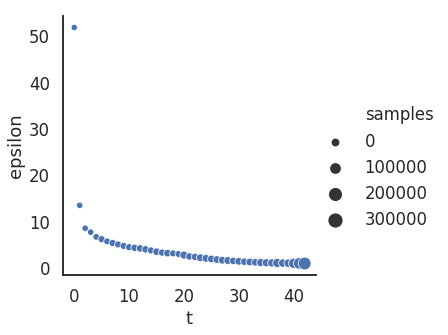

In [49]:
evolution = history.get_all_populations()
grid = sns.relplot(x='t', y='epsilon', size='samples', data=evolution[evolution.t>=0])
grid.savefig('results/ical-generic/eps_evolution.pdf')

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes height small enough '


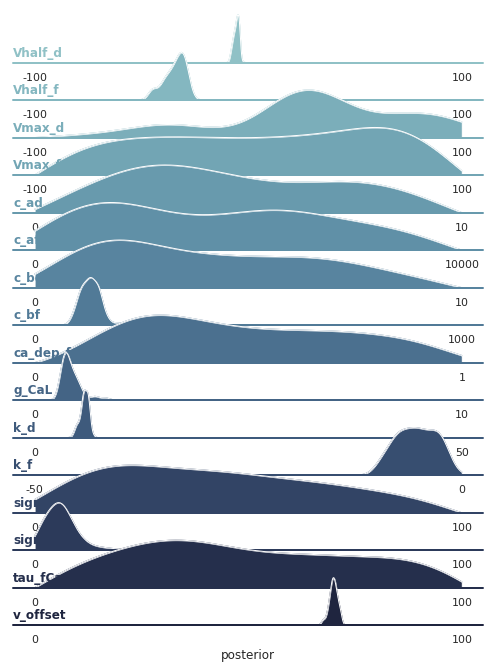

In [12]:
df, w = history.get_distribution(m=0)
g = plot_parameters_kde(df, w, limits, aspect=12, height=0.6)

In [13]:
g.savefig('results/ical-generic/parameters_kde.pdf')

# Samples for quantitative analysis

In [44]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [45]:
# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

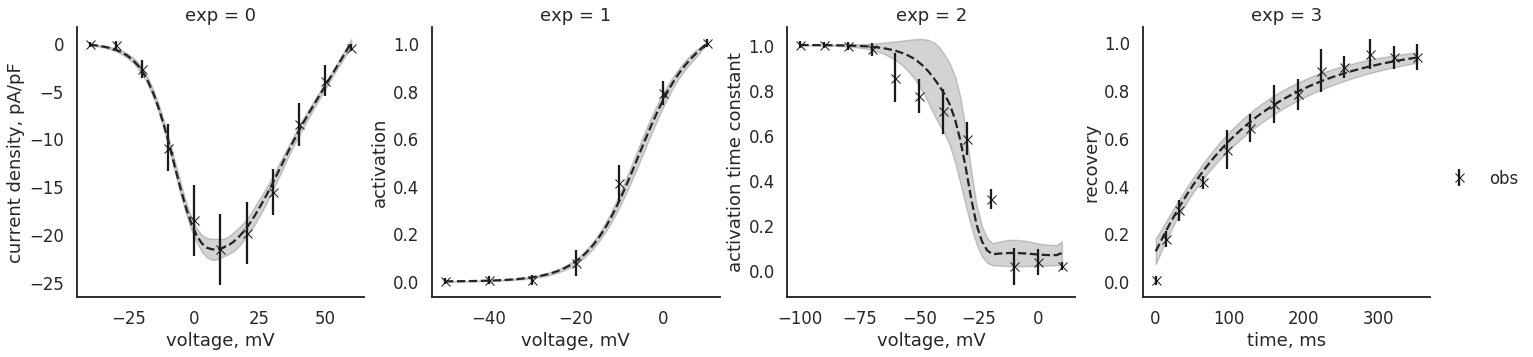

In [46]:
from ionchannelABC import plot_sim_results
sns.set_context('talk')
g = plot_sim_results(samples, obs=measurements)

# Set axis labels
xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms"]
ylabels = ["current density, pA/pF", "activation", "activation time constant", "recovery"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)

In [47]:
g.savefig('results/ical-generic/ical_sim_results.pdf')

In [50]:
# Peak current density
grouped = samples[samples['exp']==0].groupby('sample')
output = grouped.apply(min)['y']
print(output.mean())
print(output.std())

-21.9322984301561
0.8443469719876238


In [51]:
import scipy.stats as st
peak_current = samples[samples['exp']==0].groupby('sample').min()['y'].tolist()
rv = st.rv_discrete(values=(peak_current, [1/len(peak_current),]*len(peak_current)))

In [52]:
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -22.063913267457927
95% CI: (-23.212626283921935, -19.873631528347506)


In [53]:
# Half-activation voltage and slope factor
grouped = samples[samples['exp']==1].groupby('sample')
from scipy.optimize import curve_fit
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, Shalf):
        return 1/(1+np.exp((Vhalf-V)/Shalf))
    guess = (-10, 5)
    popt, _ = curve_fit(boltzmann, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [54]:
print(output.mean())
print(output.std())

0   -6.444563
1    5.370407
dtype: float64
0    0.673049
1    0.276815
dtype: float64


In [55]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -6.356274882044914
95% CI: (-7.957527996275886, -5.474399764577165)


In [56]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 5.376596330925932
95% CI: (4.814915251203161, 5.803378050945122)


In [57]:
# Half-inactivation voltage and slope factor
grouped = samples[samples['exp']==2].groupby('sample')
from scipy.optimize import curve_fit
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, Shalf):
        return 1/(1+np.exp((Vhalf-V)/Shalf))
    guess = (-30, -5)
    popt, _ = curve_fit(boltzmann, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [58]:
print(output.mean())
print(output.std())

0   -32.671586
1    -5.996784
dtype: float64
0    3.537817
1    3.444588
dtype: float64


In [59]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -31.834816002471047
95% CI: (-39.94275323178982, -26.018237457989326)


In [60]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -5.322433739420261
95% CI: (-13.00813997055706, -1.6810334273224878)


In [61]:
# Recovery dynamics
grouped = samples[samples['exp']==3].groupby('sample')
def fit_single_exp(group):
    def single_exp(t, I_max, tau):
        return I_max*(1-np.exp(-t/tau))
    guess = (1, 100)
    popt, _ = curve_fit(single_exp, group.x, group.y, guess)
    return popt[1]
output = grouped.apply(fit_single_exp).apply(pd.Series)

In [62]:
print(output.mean())
print(output.std())

0    99.214489
dtype: float64
0    10.277647
dtype: float64


In [63]:
tau = output[0].tolist()
rv = st.rv_discrete(values=(tau, [1/len(tau),]*len(tau)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 98.22675934101245
95% CI: (78.55467670149439, 116.827738415043)
